In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import copy
import time
import numpy as np
sys.path.append(os.path.join(os.path.abspath(""), ".."))

In [3]:
from app.utils import ImageWrapper
from app.custom import RemoveBusBars, Orient
from app.transforms import FFT, IFFT, CreateOnesMask
from app.filters import CreateKernel, Convolve, Canny, HOG
from app.imager import ImageLoader, DefectViewer, Show, Exposure

In [4]:
# Seed used in show to show the same images when num_images option is set
seed = 1234

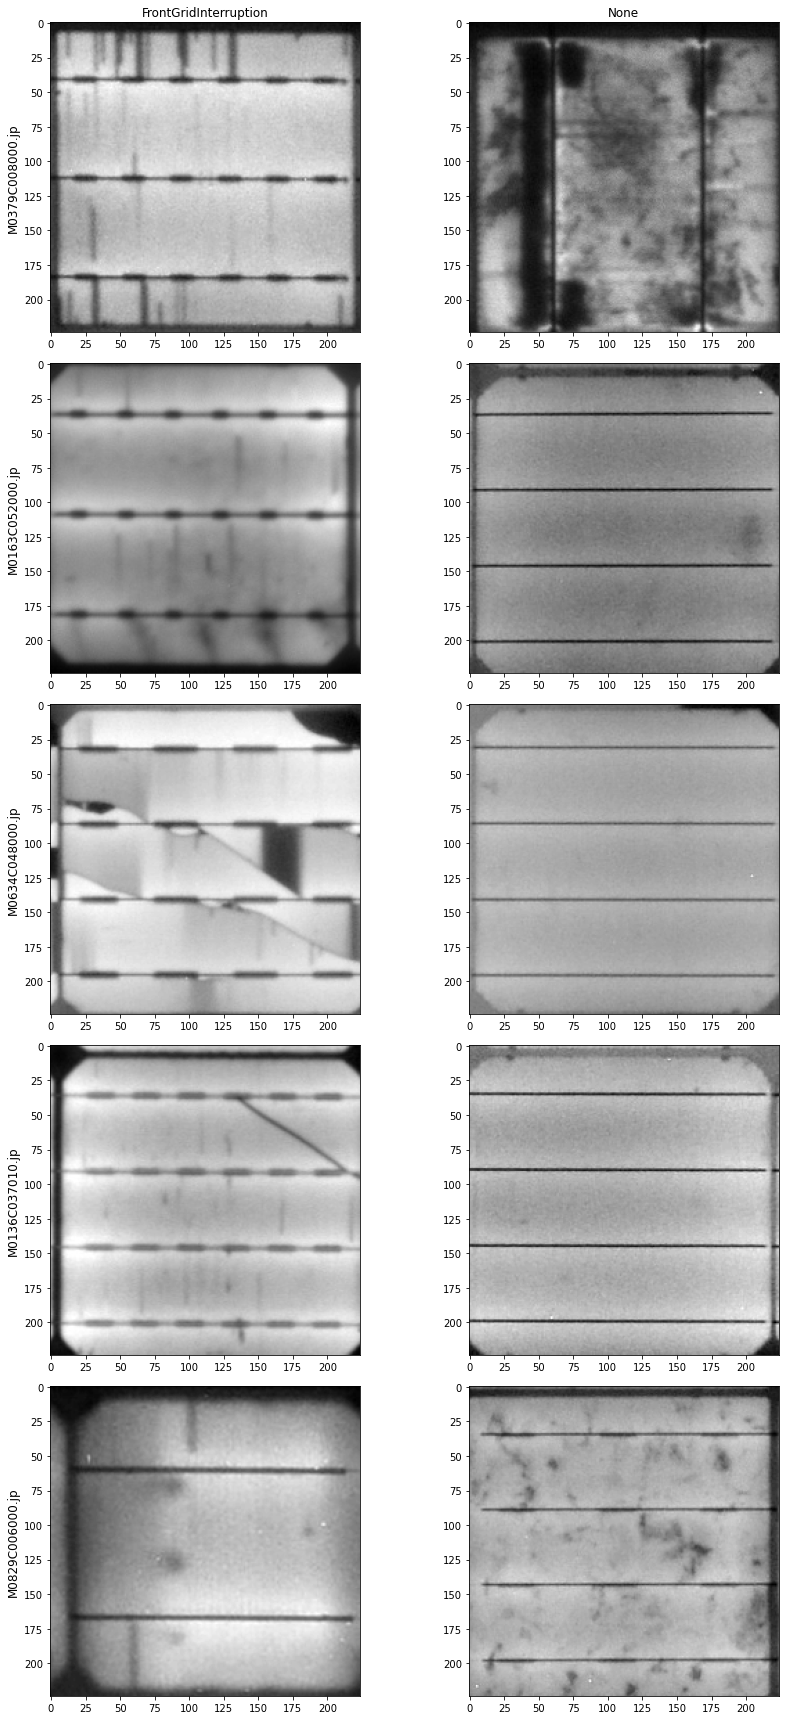

In [5]:
# Load 10 examples and name the category for it. Category is like a title for images
n_samples = 500
defect = (DefectViewer() << (ImageLoader(defect_class='FrontGridInterruption') << n_samples))
defect.category = 'FrontGridInterruption'
clean = (DefectViewer() << (ImageLoader(defect_class='None') << n_samples))
clean.category = 'None'

# View both the defect and the clean class
# I am using a tuple in this case as defect and clean are ImageWrapper objects
# Show random 5 out of the 10 images. Using the seed will ensure the same 5 are shown everytime
_ = Show(num_images=5, seed=seed) << (defect, clean)

52.93337871600124


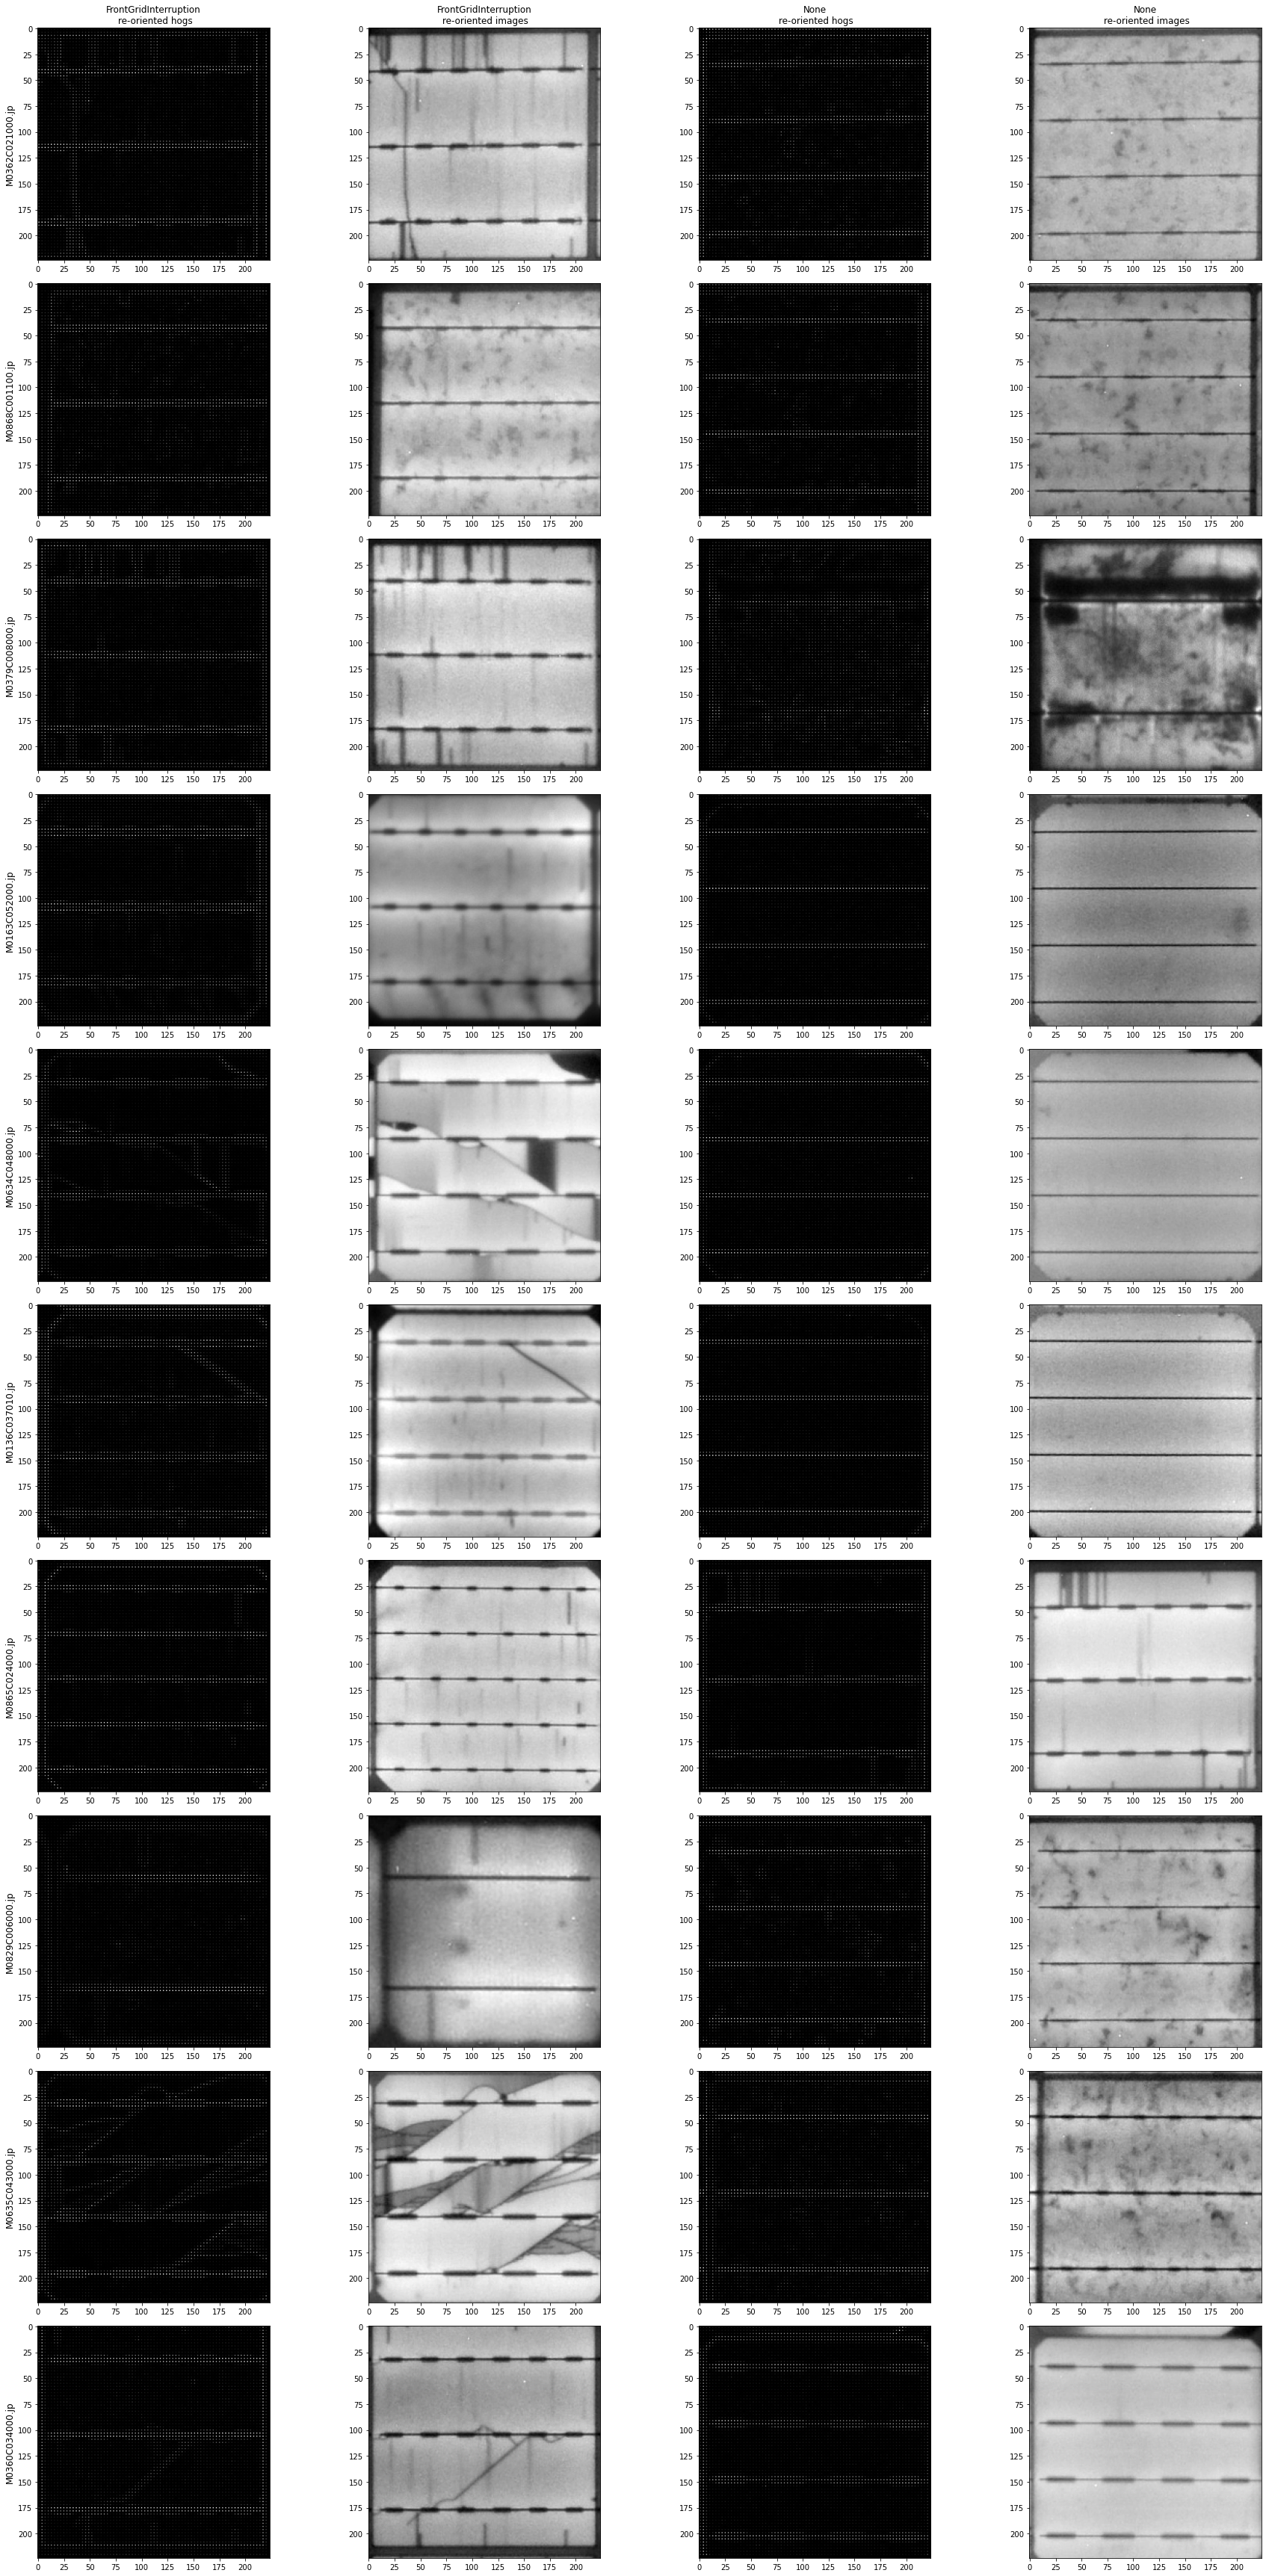

(<app.utils.ImageWrapper at 0x7fe6b1f16d90>,
 <app.utils.ImageWrapper at 0x7fe69e1dab90>)

In [6]:
# Get the oriented images and HOG
start = time.perf_counter()
oriented_defect = Orient(num_jobs=20) << defect
oriented_clean = Orient(num_jobs=20) << clean
print(time.perf_counter() - start)


# View both the defect and the clean class
# I am using + operator as oriented_defect and oriented_clean are tuples
_ = Show(num_images=10, seed=seed) << oriented_defect + oriented_clean

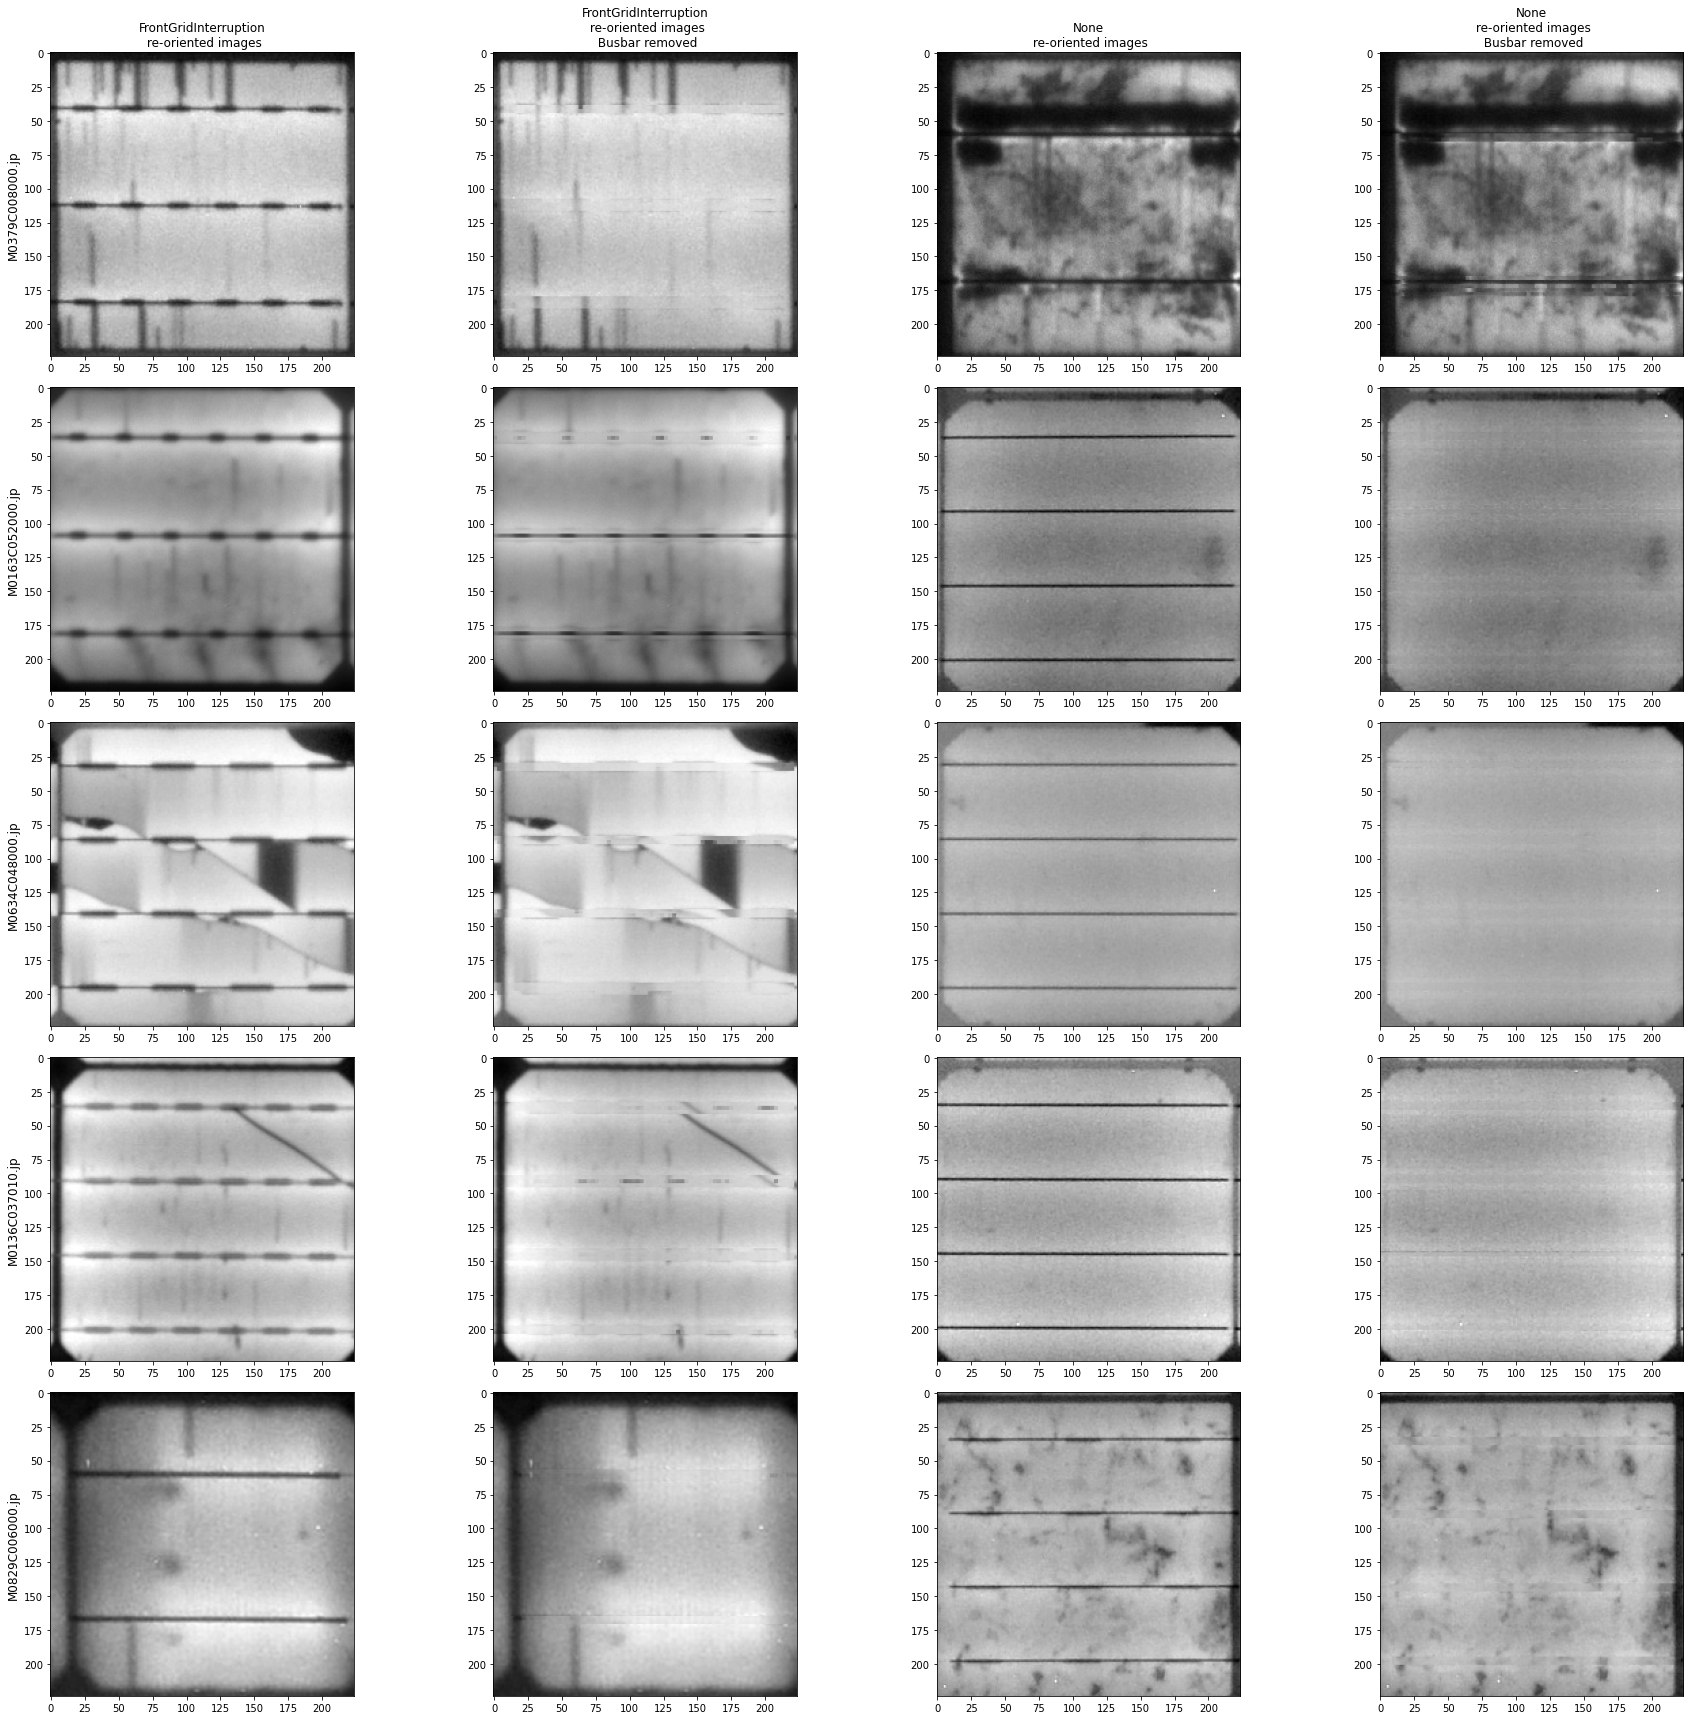

In [7]:
# Remove the BusBars
nobus_defect = RemoveBusBars() << oriented_defect
nobus_clean = RemoveBusBars() << oriented_clean

_ = Show(num_images=5, seed=seed) << nobus_defect + nobus_clean

## End of completed work

In [ ]:
defect_imw = defect_4[-1]
clean_ims = clean_4[-1]




defect_5 = (defect_imw, ImageWrapper(fix_orientation(defect_imw.images, defect.images), category=defect_imw.category + '\nrotated', image_labels=copy.deepcopy(defect_imw.image_labels)))
clean_5 = (clean_imw, ImageWrapper(fix_orientation(clean_imw.images, clean.images), category=clean_imw.category + '\nrotated', image_labels=copy.deepcopy(clean_imw.image_labels)))

_ = Show(num_images=10, seed=seed) << defect_5 + clean_5

In [ ]:
import matplotlib.pyplot as plt
sum_gradients_x = np.sum(defect_4[-1].images, axis=-1, keepdims=False)    
bins, counts = np.unique((sum_gradients_x).astype(int), return_counts=True)

In [ ]:
plt.plot(bins, np.log10(counts))

In [ ]:
import copy

defect_imw = defect_4[-1]
defect_5 = (defect, ImageWrapper(defect_imw.images + defect.images, category=defect_imw.category + '\n added', image_labels=copy.deepcopy(defect_imw.image_labels)))

# defect_2 and clean_2 are tuples, so adding them up to make one tuple
_ = Show(num_images=5, seed=seed) << defect_5

In [ ]:
bus_higlighted_defect = Exposure('sigmoid', cutoff=0.2) << (Exposure('adaptive', ) << defect)
bus_higlighted_clean = Exposure('sigmoid', cutoff=0.2) << (Exposure('adaptive') << clean)

_ = Show(num_images=5, seed=seed) << (defect, ) + bus_higlighted_defect + (clean, ) + bus_higlighted_clean

In [ ]:
defect_contrast = Convolve() << (CreateKernel(dim=2, kernel='gaussian', size=3, std=8) << (Exposure('mean_norm') << defect))
clean_contrast = Convolve() << (CreateKernel(dim=2, kernel='gaussian', size=3, std=8) << (Exposure('mean_norm') << clean))

# Show defective and clean images
_ = Show(num_images=5, seed=seed) << (defect, ) + defect_contrast + (clean, ) + clean_contrast

In [ ]:
defect_contrast_1 = Exposure('adaptive') << defect_contrast
clean_contrast_1 = Exposure('adaptive') << clean_contrast

# Show defective and clean images
_ = Show(num_images=5, seed=seed) << defect_contrast_1 + clean_contrast_1

In [ ]:
def make_gi_2_kernel(finger_width=2, finger_height=6, side_padding=2, top_padding=2, flipped=False):
    """
    """
    
    if (finger_height + top_padding) % 2 == 0:
        top_padding += 1
    
    # 
    width = finger_width + 2*side_padding
    height = finger_height + top_padding
    
    total_size = width * height
    finger_size = finger_width*finger_height
    
    outer_weight = 1/(total_size - finger_size)
    finger_weight = 1/finger_size
    
    kernel = np.ones((width, height)) * outer_weight

    kernel[side_padding:side_padding+finger_width, :finger_height] = -finger_weight
    
    if kernel.shape[0] % 2 == 0:
        kernel = np.vstack((kernel, np.zeros((kernel.shape[1], ))))
        
    return kernel.T

In [ ]:
interrupt_kernel = make_gi_2_kernel(finger_width=3, finger_height=10, top_padding=1, side_padding=1)
defect_isolated = Convolve() << (CreateKernel(kernel='custom', custom_kernel=interrupt_kernel) << defect_contrast_1)
clean_isolated = Convolve() <<  (CreateKernel(kernel='custom', custom_kernel=interrupt_kernel) << clean_contrast_1)

# Show defective and clean images
_ = Show(num_images=5, seed=seed) << (defect, ) + defect_isolated + (clean, ) + clean_isolated

In [ ]:
for _ in range(3):
    defect_isolated = Exposure('invert') << defect_isolated
    clean_isolated = Exposure('invert') << clean_isolated
    
    defect_isolated = Convolve() << (CreateKernel(kernel='custom', custom_kernel=interrupt_kernel) << defect_isolated)
    clean_isolated = Convolve() <<  (CreateKernel(kernel='custom', custom_kernel=interrupt_kernel) << clean_isolated)
    _ = Show(num_images=10) << defect_isolated + clean_isolated

In [ ]:
defect_sigmoid = Exposure('sigmoid', inverse=True) << defect_isolated
clean_sigmoid = Exposure('sigmoid', inverse=True) << clean_isolated
_ = Show(num_images=10) << (defect, ) + defect_sigmoid + (clean, ) + clean_sigmoid

In [ ]:
_ = Show() << (FFT(dim=2) << defect_sigmoid)

In [ ]:
cm = CreateOnesMask(defect_sigmoid[-1])
# mask = cm.horizontal_from_center(left_width=10, right_width=10, height=3, val=0)
# mask = cm.vertical_from_center(top_height=10, bottom_height=10, width=10, val=0)
mask = cm.center_circle(radius=100)
images = Show(do_show=True) << (IFFT(mask) << (Show(do_show=False) << (FFT(dim=2) << defect_sigmoid)))

In [ ]:
import matplotlib.pyplot as plt
plt.hist(defect_isolated[-1].flatten(), color='blue')
plt.hist(clean_isolated[-1].flatten(), color='red')

In [ ]:
np.set_printoptions(precision=2)
k = make_gi_2_kernel(finger_width=4, finger_height=6, top_padding=3)
print(k.shape)
print(k)

In [ ]:
import numpy as np
def make_gi_kernel(finger_width=2, finger_height=6, side_padding=2, top_padding=2, flipped=False):
    """
    """
    
    if (finger_height + top_padding) % 2 == 0:
        top_padding += 1
    
    # 
    width = finger_width + 2*side_padding
    height = finger_height + top_padding
    
    kernel = np.zeros((width, height))
    
    # Side pad weight is 1/the number of elements in it
    padded_area_weight = 1/(side_padding * height)
    # print(f'Padded area weight {padded_area_weight}')
        
    kernel[:side_padding, :] = padded_area_weight
    kernel[-side_padding:, :] = -padded_area_weight
    
    # These are the
    symmetric_elements = int(finger_width/2)
    top_pad_weight = 1/(symmetric_elements *top_padding)
    # print(f'Top pad weight {top_pad_weight}')
   
    # Setup the padding for the bottom
    kernel[side_padding:side_padding+symmetric_elements, finger_height:] = top_pad_weight
    kernel[-(side_padding+symmetric_elements):-side_padding, finger_height:] = -top_pad_weight
    
    # Setup the weights for the finger
    finger_weight = 1/(finger_width*finger_height)
    kernel[side_padding:side_padding+finger_width, :finger_height] = finger_weight
    
    return kernel.T

In [ ]:
a = np.ones((2, 2))

In [ ]:
a